#Mount Google Drive to access videos

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


# Frame extraction => run the cell only once

In [ ]:
'''

import cv2
import os

# Function to extract 30 frames from a video and save them
def extract_fixed_frames_from_video(video_path, output_folder, num_frames=30):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the frame step to extract the given number of frames
    frame_step = total_frames // num_frames if total_frames > num_frames else 1

    frame_count = 0
    extracted_count = 0

    success, frame = video.read()

    while success and extracted_count < num_frames:
        # Save the frame at the calculated step interval
        if frame_count % frame_step == 0:
            frame_name = os.path.join(output_folder, f"frame_{extracted_count:03d}.png")
            cv2.imwrite(frame_name, frame)  # Save the frame
            extracted_count += 1

        success, frame = video.read()
        frame_count += 1

    video.release()  # Release the video after processing
    print(f"Extracted {extracted_count} frames from {video_path} and saved to {output_folder}")

# Directories for real and fake video frames
real_video_dir = '/content/drive/MyDrive/uadfv/real'
fake_video_dir = '/content/drive/MyDrive/uadfv/fake'

# Extract 30 frames from each real video in the real directory
real_frames_dir = '/content/drive/MyDrive/uadfv/real/frames'
for video_file in os.listdir(real_video_dir):
    if video_file.endswith('.mp4'):
        video_path = os.path.join(real_video_dir, video_file)
        extract_fixed_frames_from_video(video_path, os.path.join(real_frames_dir, video_file.split('.')[0]), num_frames=30)

# Extract 30 frames from each fake video in the fake directory
fake_frames_dir = '/content/drive/MyDrive/uadfv/fake/frames'
for video_file in os.listdir(fake_video_dir):
    if video_file.endswith('.mp4'):
        video_path = os.path.join(fake_video_dir, video_file)
        extract_fixed_frames_from_video(video_path, os.path.join(fake_frames_dir, video_file.split('.')[0]), num_frames=30)

'''


Extracted 30 frames from /content/drive/MyDrive/uadfv/real/0009.mp4 and saved to /content/drive/MyDrive/uadfv/real/frames/0009
Extracted 30 frames from /content/drive/MyDrive/uadfv/real/0000.mp4 and saved to /content/drive/MyDrive/uadfv/real/frames/0000
Extracted 30 frames from /content/drive/MyDrive/uadfv/real/0001.mp4 and saved to /content/drive/MyDrive/uadfv/real/frames/0001
Extracted 30 frames from /content/drive/MyDrive/uadfv/real/0006.mp4 and saved to /content/drive/MyDrive/uadfv/real/frames/0006
Extracted 30 frames from /content/drive/MyDrive/uadfv/real/0007.mp4 and saved to /content/drive/MyDrive/uadfv/real/frames/0007
Extracted 30 frames from /content/drive/MyDrive/uadfv/real/0003.mp4 and saved to /content/drive/MyDrive/uadfv/real/frames/0003
Extracted 30 frames from /content/drive/MyDrive/uadfv/real/0008.mp4 and saved to /content/drive/MyDrive/uadfv/real/frames/0008
Extracted 30 frames from /content/drive/MyDrive/uadfv/real/0011.mp4 and saved to /content/drive/MyDrive/uadfv/r

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up ImageDataGenerator for preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    validation_split=0.2  # Split the data into training and validation sets
)

#training data
# Load training data (real and fake frames) from the 'real/frames' and 'fake/frames' directories
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/uadfv/',  # Parent directory containing 'real/frames' and 'fake/frames'
    target_size=(224, 224),  # Resize frames to match model input size (224x224 for XceptionNet)
    batch_size=32,
    class_mode='binary',  # Binary classification (real vs fake)
    subset='training',  # Specify that this is the training data
    classes=['real', 'fake']  # Subdirectories for real and fake classes
)


#validation data
valid_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/uadfv/',  # Parent directory containing 'real/frames' and 'fake/frames'
    target_size=(224, 224),  # Resize frames to match model input size
    batch_size=32,
    class_mode='binary',  # Binary classification (real vs fake)
    subset='validation',  # Specify that this is the validation data
    classes=['real', 'fake']  # Subdirectories for real and fake classes
)


Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


#Training - Xception

In [ ]:
#Step 1: Load the Pretrained Xception Model

import tensorflow as tf
from tensorflow.keras import layers, models

# Load the pre-trained Xception model without the top classification layer
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model (so they are not updated during training)
base_model.trainable = False

# Build a custom model on top of the Xception base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification: real or fake
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [ ]:


# Step 1: Define the model (using pre-trained Xception as base model)
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the top layers of Xception for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Unfreeze the top 100 layers
    layer.trainable = False

# Build a custom model on top of Xception
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Adjusted dropout
    layers.Dense(1, activation='sigmoid')  # Binary classification (real vs fake)
])

# Compile the model with an increased learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Step 2: Set up data augmentation and preprocessing for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=10,  # Less aggressive rotation
    width_shift_range=0.1,  # Smaller horizontal shifts
    height_shift_range=0.1,  # Smaller vertical shifts
    shear_range=0.1,  # Reduced shear
    zoom_range=0.1,  # Smaller zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=0.2  # Split data into training and validation sets
)

# Load training data from 'real/frames' and 'fake/frames' directories
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/uadfv/',  # Parent directory containing 'real/frames' and 'fake/frames'
    target_size=(224, 224),  # Resize frames to match model input size (224x224 for XceptionNet)
    batch_size=32,  # Set batch size to 32 (smaller batch size for stability)
    class_mode='binary',  # Binary classification (real vs fake)
    subset='training',  # Specify that this is the training data
    classes=['real', 'fake']  # Subdirectories for real and fake classes
)

valid_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/uadfv/',  # Parent directory containing 'real/frames' and 'fake/frames'
    target_size=(224, 224),  # Resize frames to match model input size
    batch_size=32,  # Set batch size to 32
    class_mode='binary',  # Binary classification (real vs fake)
    subset='validation',  # Specify that this is the validation data
    classes=['real', 'fake']  # Subdirectories for real and fake classes
)

# Step 3: Set up callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/models/my_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Increased patience

# Step 4: Train the model with the callbacks
history = model.fit(
    train_generator,
    epochs=10,  # Train for 20 epochs, you can adjust based on performance
    validation_data=valid_generator,
    callbacks=[checkpoint, early_stopping]  # Use checkpoint and early stopping during further training
)

# The best model is automatically saved by ModelCheckpoint during training, so no need to save it again.
# If needed, the best model is saved in '/content/drive/MyDrive/models/my_model.keras'


Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.5726 - loss: 13.0565 - val_accuracy: 0.6883 - val_loss: 10.0641
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 113s 978ms/step - accuracy: 0.9008 - loss: 8.4491 - val_accuracy: 0.9100 - val_loss: 6.2060
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 950ms/step - accuracy: 0.9518 - loss: 5.4569 - val_accuracy: 0.9150 - val_loss: 4.0624
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 953ms/step - accuracy: 0.9609 - loss: 3.4585 - val_accuracy: 0.9233 - val_loss: 2.5385
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9692 - loss: 2.1514 - val_accuracy: 0.9333 - val_loss: 1.6336
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 71s 952ms/step - accuracy: 0.9611 - loss: 1.3103 - val_accuracy: 0.9367 - val_loss: 1.0429
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 72s 954ms/step - accuracy: 0.9675 - loss: 0.8022 - val_accuracy: 0.9383 - val_loss: 0.7003
Epoch 8/10
75/75

<br>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Step 1: Define the model (using pre-trained Xception as the base model)
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the top layers of Xception for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Unfreeze the top 100 layers
    layer.trainable = False

# Build a custom model on top of Xception
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.3),  # Adjusted dropout
    layers.Dense(1, activation='sigmoid')  # Binary classification (real vs fake)
])

# Compile the model with an increased learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Step 2: Set up data augmentation and preprocessing for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=10,  # Less aggressive rotation
    width_shift_range=0.1,  # Smaller horizontal shifts
    height_shift_range=0.1,  # Smaller vertical shifts
    shear_range=0.1,  # Reduced shear
    zoom_range=0.1,  # Smaller zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    validation_split=0.2  # Split data into training and validation sets
)

# Load training data from 'real/frames' and 'fake/frames' directories
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/uadfv/',  # Parent directory containing 'real/frames' and 'fake/frames'
    target_size=(224, 224),  # Resize frames to match model input size (224x224 for XceptionNet)
    batch_size=32,  # Set batch size to 32 (smaller batch size for stability)
    class_mode='binary',  # Binary classification (real vs fake)
    subset='training',  # Specify that this is the training data
    classes=['real', 'fake']  # Subdirectories for real and fake classes
)

valid_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/uadfv/',  # Parent directory containing 'real/frames' and 'fake/frames'
    target_size=(224, 224),  # Resize frames to match model input size
    batch_size=32,  # Set batch size to 32
    class_mode='binary',  # Binary classification (real vs fake)
    subset='validation',  # Specify that this is the validation data
    classes=['real', 'fake']  # Subdirectories for real and fake classes
)

# Step 3: Set up callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/models/deepfake_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Increased patience

# Step 4: Train the model with the callbacks
history = model.fit(
    train_generator,
    epochs=10,  # Train for 10 epochs (adjust as needed)
    validation_data=valid_generator,
    callbacks=[checkpoint, early_stopping]  # Use checkpoint and early stopping during further training
)

# The best model is automatically saved by ModelCheckpoint during training, so no need to save it again.
# If needed, the best model is saved in '/content/drive/MyDrive/models/deepfake_model.keras'


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2293s 30s/step - accuracy: 0.5724 - loss: 13.0459 - val_accuracy: 0.6383 - val_loss: 10.0534
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 62s 820ms/step - accuracy: 0.9222 - loss: 8.3122 - val_accuracy: 0.9033 - val_loss: 6.1376
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 845ms/step - accuracy: 0.9561 - loss: 5.2994 - val_accuracy: 0.9267 - val_loss: 3.8640
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 916ms/step - accuracy: 0.9612 - loss: 3.3270 - val_accuracy: 0.9433 - val_loss: 2.3858
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 901ms/step - accuracy: 0.9666 - loss: 2.0290 - val_accuracy: 0.9383 - val_loss: 1.4991
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 907ms/step - accuracy: 0.9688 - loss: 1.2179 - val_accuracy: 0.9467 - val_loss: 0.9287
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 901ms/step - accuracy: 0.9721 - loss: 0.7233 - val_accuracy: 0.8900 - val_loss: 0.8189
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 895ms/step - accuracy: 0.9711 - loss: 0.4366 - val_ac

<br>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Load the model from the saved path
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/models/my_model.keras')

# Check model summary
loaded_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,115,773 (175.92 MB)

 Trainable params: 11,577,545 (44.16 MB)

 Non-trainable params: 11,383,136 (43.42 MB)

 Optimizer params: 23,155,092 (88.33 MB)

In [ ]:

# Load the previously saved model
model = load_model('/content/drive/MyDrive/models/my_model.keras')

# Evaluate on validation data
loss, acc = model.evaluate(valid_generator)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {acc:.4f}")


NameError: name 'load_model' is not defined

In [ ]:
import pickle

with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Now manually plot
import matplotlib.pyplot as plt

plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


NameError: name 'history' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Check which keys are available
print(history.keys())

# Plot training and validation loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
if 'accuracy' in history:
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
elif 'acc' in history:
    plt.plot(history['acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
else:
    print("No accuracy data available in history.")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


NameError: name 'history' is not defined

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/models/my_model.keras')
loss, acc = model.evaluate(valid_generator)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {acc:.4f}")


NameError: name 'valid_generator' is not defined

In [ ]:
# Assuming your model is already loaded
model = tf.keras.models.load_model('/content/drive/MyDrive/models/my_model.keras')

# Assuming you already have a validation generator or dataset
val_loss, val_accuracy = model.evaluate(valid_generator)  # You can replace valid_generator with your actual data generator

# Print out the validation accuracy and loss
print(f"Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}")


NameError: name 'tf' is not defined

<br>

#Predicting if the video provided is real or fake

In [ ]:

import cv2
import numpy as np
import tensorflow as tf

# Function to extract frames from the video (no saving, just processing)
def extract_frames_from_video(input_video_path, num_frames=30):
    # Initialize OpenCV VideoCapture
    cap = cv2.VideoCapture(input_video_path)

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate frame step to get a fixed number of frames
    frame_step = total_frames // num_frames if total_frames > num_frames else 1

    frames = []
    frame_count = 0

    success, frame = cap.read()
    while success:
        # Only extract the required frames, skipping intermediate frames
        if frame_count % frame_step == 0:
            frame_resized = cv2.resize(frame, (224, 224))  # Resize to match model input
            frame_normalized = frame_resized / 255.0  # Normalize pixel values
            frames.append(frame_normalized)

        success, frame = cap.read()
        frame_count += 1

    cap.release()
    return np.array(frames)

# Function to classify a video as real or fake by classifying frames individually
def classify_video(input_video_path, model, num_frames=30):
    frames = extract_frames_from_video(input_video_path, num_frames)  # Extract frames from video

    # Predict each frame individually
    predictions = []
    for frame in frames:
        frame = np.expand_dims(frame, axis=0)  # Add batch dimension (1, 224, 224, 3)
        prediction = model.predict(frame)  # Predict the class of the frame
        predictions.append(prediction)

    # Convert list of predictions to numpy array and calculate the average
    predictions = np.array(predictions)

    # Aggregate predictions (majority vote based on average score)
    majority_vote = np.mean(predictions) > 0.5  # If more than 50% frames are fake, classify as fake

    # Final classification based on majority vote
    return "Fake" if majority_vote else "Real"

# Load your trained model (ensure it's already trained and saved)
model = tf.keras.models.load_model('/content/drive/MyDrive/models/my_model.keras')

# **Set the path to your video file here**
input_video_path = '/content/drive/MyDrive/uadfv/test_data/vs1.mp4'  # Replace with your actual video file path

# Classify the video
result = classify_video(input_video_path, model)
print(f"The video is classified as: {result}")


The video is classified as: Real


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


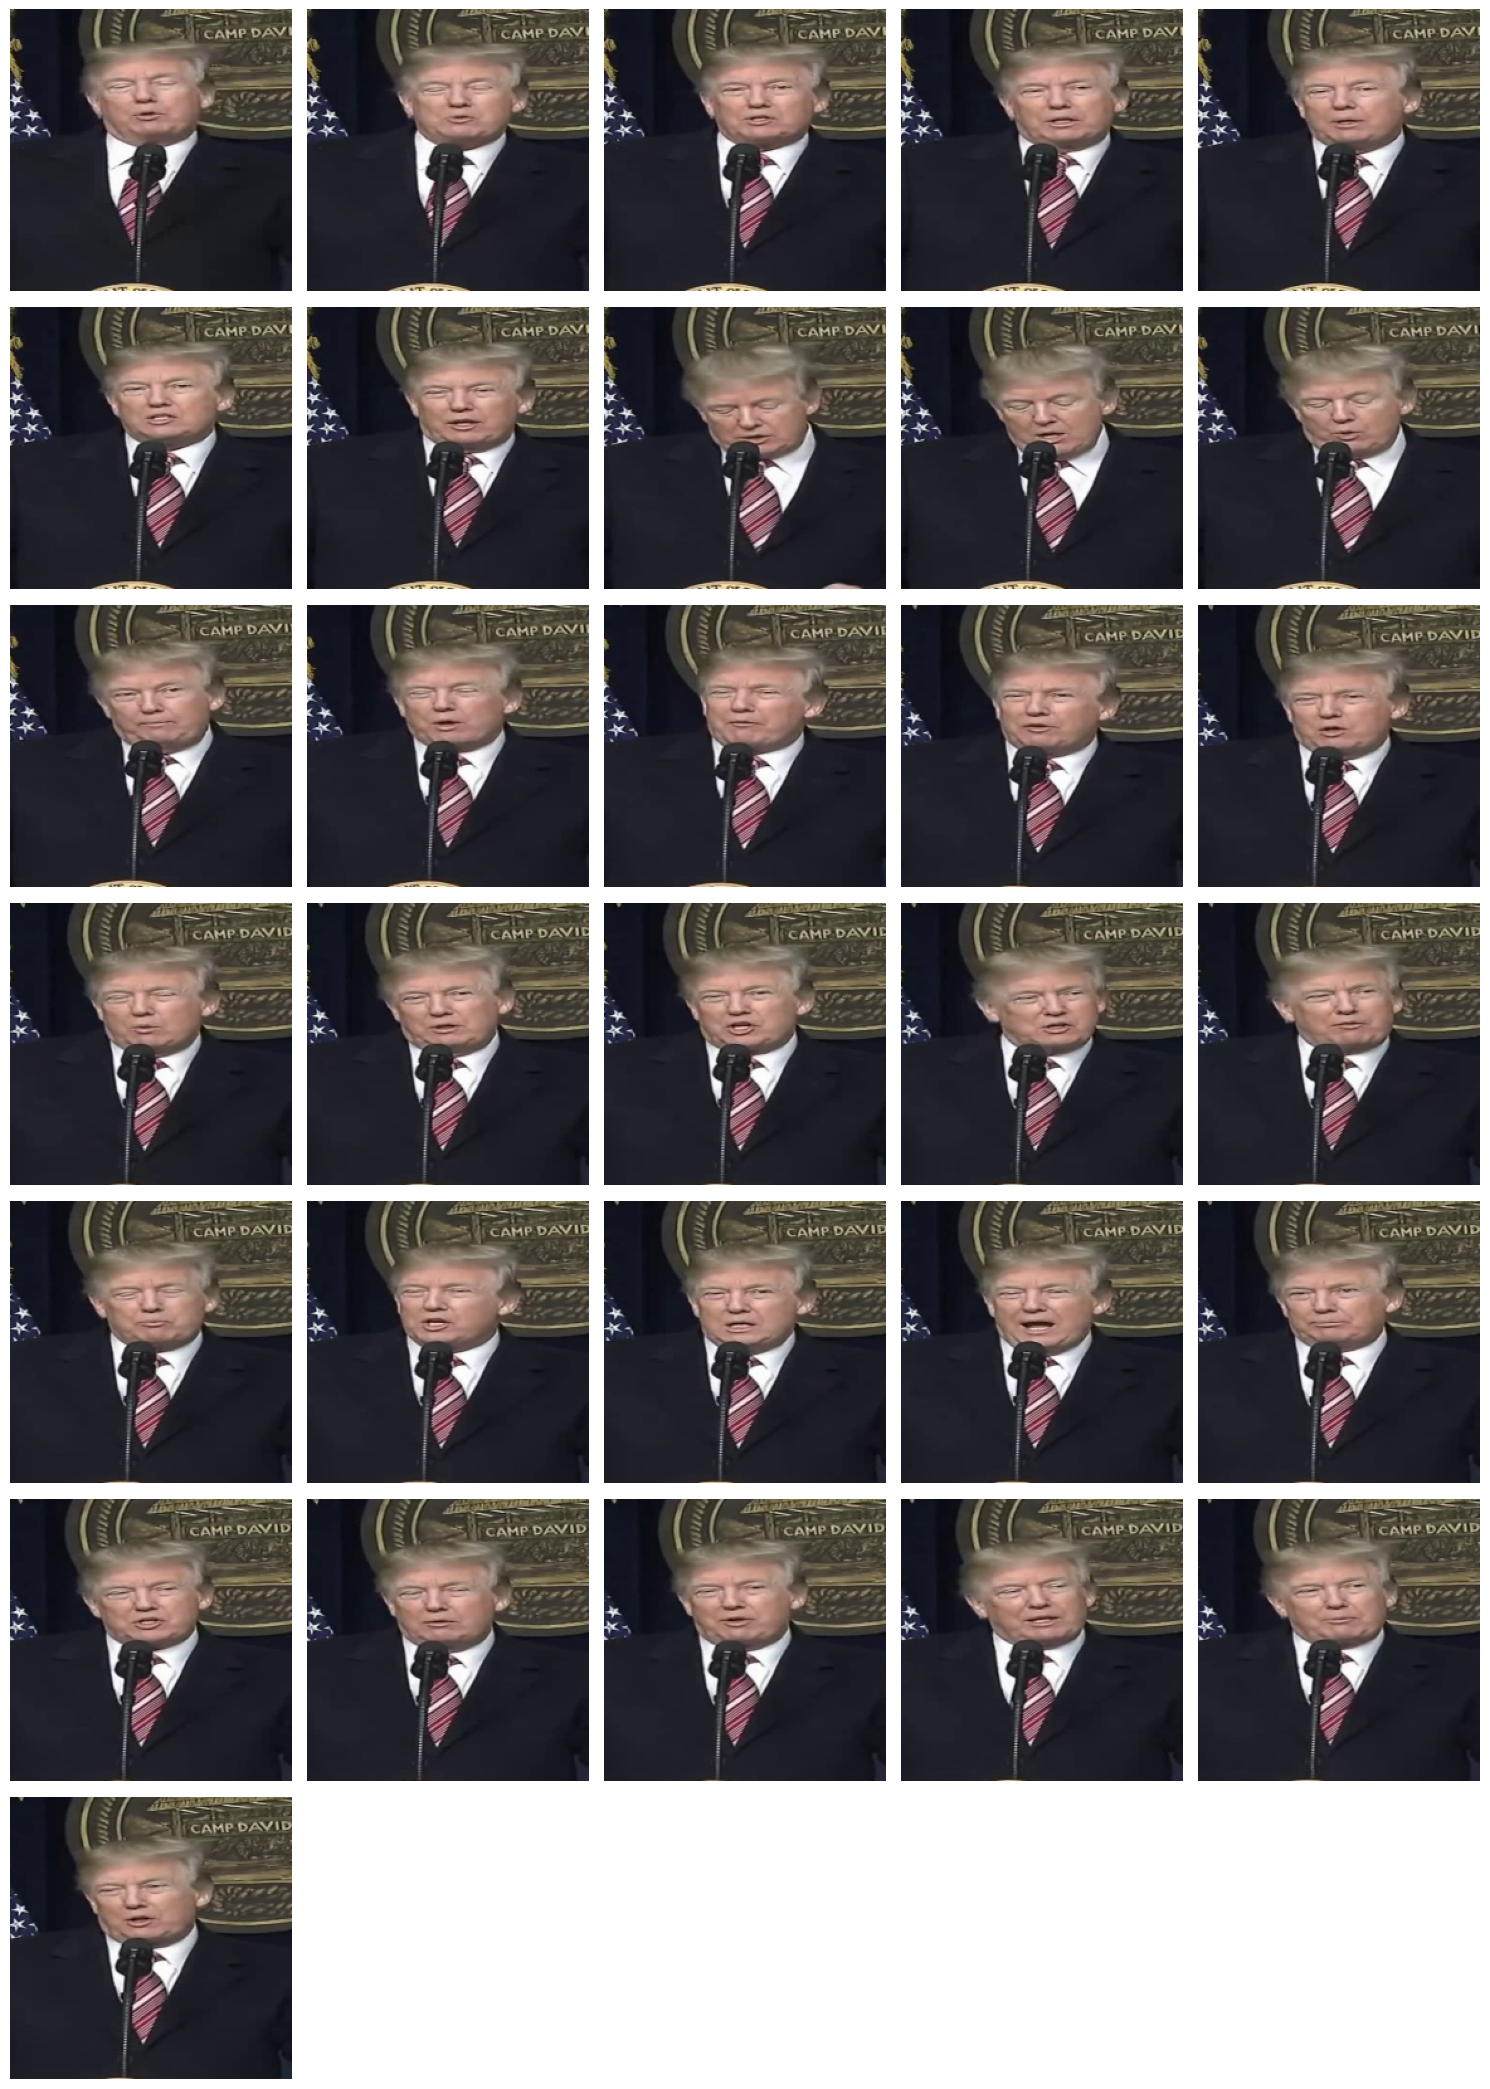

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to extract frames from the video (no saving, just processing)
def extract_frames_from_video(input_video_path, num_frames=30, images_per_row=5):
    # Initialize OpenCV VideoCapture
    cap = cv2.VideoCapture(input_video_path)

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate frame step to get a fixed number of frames
    frame_step = total_frames // num_frames if total_frames > num_frames else 1

    frames = []
    frame_count = 0
    success, frame = cap.read()

    while success:
        # Only extract the required frames, skipping intermediate frames
        if frame_count % frame_step == 0:
            frame_resized = cv2.resize(frame, (224, 224))  # Resize to match model input
            frames.append(frame_resized)

        success, frame = cap.read()
        frame_count += 1

    cap.release()

    # Display frames side by side
    num_images = len(frames)
    rows = (num_images + images_per_row - 1) // images_per_row  # Calculate number of rows

    # Create subplots
    fig, axes = plt.subplots(rows, images_per_row, figsize=(images_per_row * 3, rows * 3))
    axes = axes.flatten()  # Flatten the 2D array of axes to easily index it

    # Loop through the frames and display them
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
            ax.axis('off')  # Hide the axis
        else:
            ax.axis('off')  # Hide empty axes if the number of frames is less than the number of subplots

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

# **Set the path to your video file here**
input_video_path = '/content/drive/MyDrive/uadfv/test_data/v102.mp4'  # Replace with your actual video file path

# Display the frames extracted from the video side by side
extract_frames_from_video(input_video_path, num_frames=30, images_per_row=5)
